In [220]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy


hits_true = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear_2sigma.h5","hits")

display(hits)

,event_id,x,y,z,energy
0,0,-9.686063,9.118135,2976.856934,0.000025
1,0,-7.662766,3.790255,2978.549072,0.000025
2,0,-18.139141,9.585156,2979.713379,0.000025
3,0,-21.729176,9.672444,2979.960693,0.000025
4,0,-9.243780,3.125516,2982.464600,0.000025
...,...,...,...,...,...
98558,9,59.232395,59.891972,3027.671631,0.000025
98559,9,56.605495,61.871990,3028.720459,0.000025
98560,9,57.899887,65.571022,3028.821045,0.000025
98561,9,59.743629,61.281349,3030.394043,0.000025


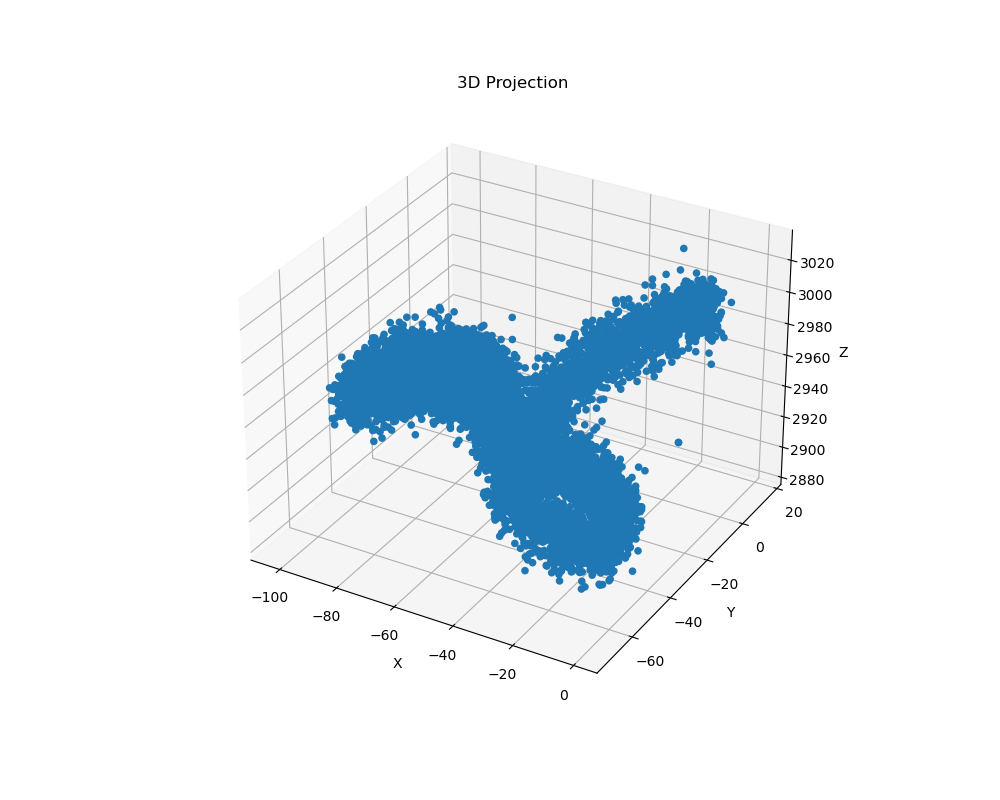

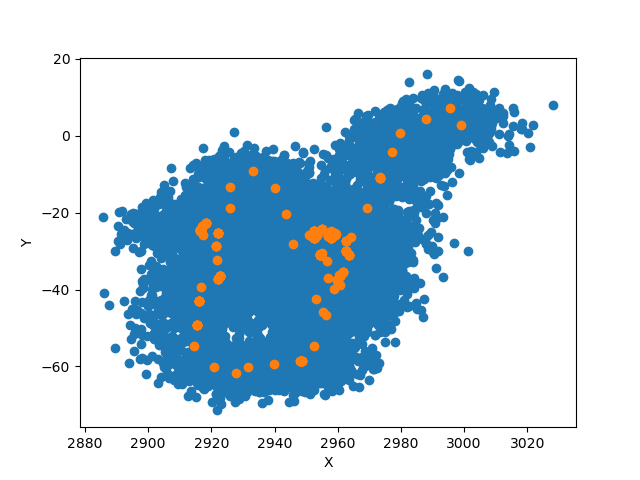

In [324]:
%matplotlib widget 
data = hits[hits.event_id ==3]
data_true = hits_true[hits_true.event_id ==3]

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=1)
ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()


plt.figure()
plt.scatter(data['z'], data['y'], marker='o')
plt.scatter(data_true['z']+3000, data_true['y'], marker='o')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



In [249]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

display(data)
print(len(dist_matrix))

,x,y,z,energy
0,-102.786049,-47.189541,2955.499268,0.000025
1,-102.128868,-49.823071,2958.781006,0.000025
2,-102.014549,-47.869411,2948.134033,0.000025
3,-101.917625,-48.477989,2956.491943,0.000025
4,-101.872002,-47.088272,2956.208496,0.000025
...,...,...,...,...
14420,-1.857812,-49.187630,2906.347168,0.000025
14421,-1.353443,-46.142689,2915.526855,0.000025
14422,-0.771406,3.350538,3008.781738,0.000025
14423,0.088568,-55.940487,2920.142822,0.000025


14425


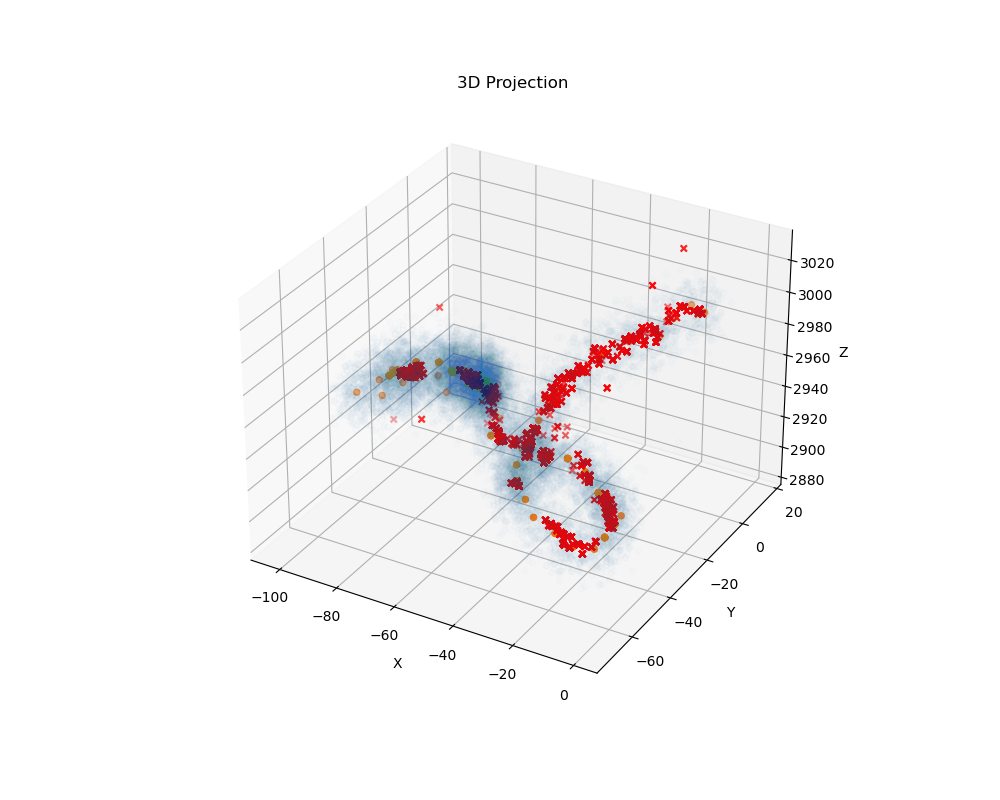

In [323]:

all_visited = []


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def GetMinima(index):

    visited = []
    found_min = False
    minimum_index = 0

    while not found_min:

        distances_from_index = dist_matrix[index] # distances for node to others
        sorted_indices = np.argsort(distances_from_index) # indexes sorted by smallest distance

        closest_nodes = sorted_indices[distances_from_index[sorted_indices] < 10]

        selected_rows = data.iloc[closest_nodes] # Df containing the nodes within distance

        # Compute the mean of x, y, and z columns
        mean_x = selected_rows['x'].median()
        mean_y = selected_rows['y'].median()
        mean_z = selected_rows['z'].median()
        mean_point = np.array([mean_x, mean_y, mean_z])

        # Compute the distance from each row to the mean point
        distances = selected_rows.apply(lambda row: np.linalg.norm(np.array([row['x'], row['y'], row['z']]) - mean_point), axis=1)

        # Find the index of the row with the smallest distance
        closest_index = distances.idxmin()

        if (closest_index in visited):
            # we have aleady been to this node
            found_min = True
            minimum_index = closest_index
        else:
            visited.append(closest_index)
            all_visited.append(closest_index)
            index = closest_index

    return minimum_index



node_centers = []

for i in range(len(data)):

    random_index = np.random.randint(0, len(data)) # pick a random index
    minimum_index = GetMinima(random_index)

    if (minimum_index >0):
        node_centers.append(minimum_index)
    

selected_rows = data.iloc[node_centers]



# Plot in 3D
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')
# colors = ['r' if count == 1 or count == 0 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o')

# ax.scatter(data.loc[random_index]['x'], data.loc[random_index]['y'], data.loc[random_index]['z'], marker='o')
ax.scatter(selected_rows['x'], selected_rows['y'], selected_rows['z'], marker='x',c="r")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()




,x,y,z,energy
32123,-23.168423,-28.669399,2901.827148,0.000025
32129,-21.993038,-27.656342,2902.179932,0.000025
32147,-20.328966,-38.851299,2902.941162,0.000025
32190,-20.930124,-31.701092,2903.913330,0.000025
32216,-21.139252,-35.014458,2904.484619,0.000025
...,...,...,...,...
46370,-21.278444,0.294210,3007.671875,0.000025
46383,-22.678774,-2.644096,3008.848877,0.000025
46393,-24.105951,5.823462,3012.203857,0.000025
46400,-20.172228,7.183969,3015.521484,0.000025


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_67552/582131765.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white', alpha=0)


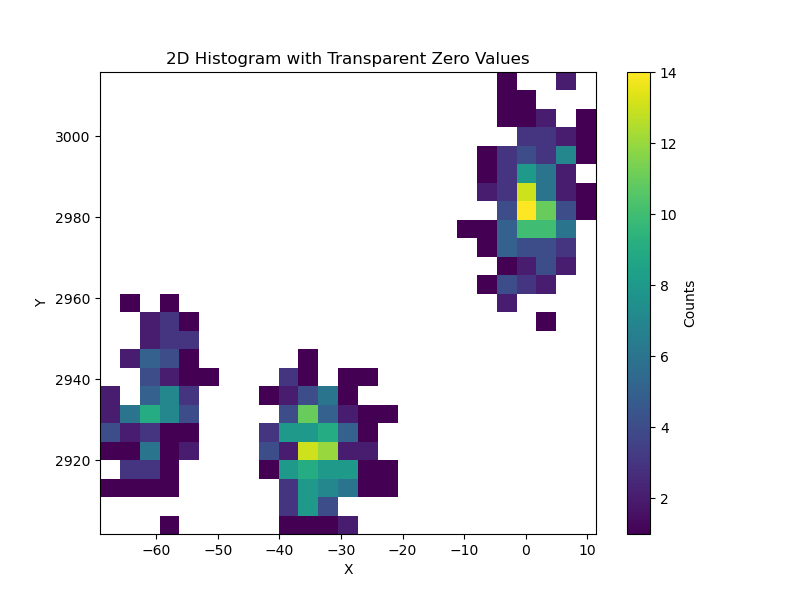

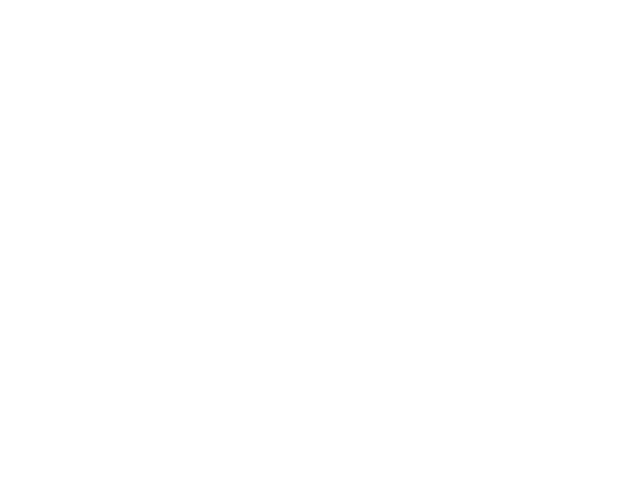

In [229]:
plt.figure()

slice  = data[(data.x > -25) & (data.x <-20)]
display(slice)

# Create a 2D histogram
hist, xedges, yedges = np.histogram2d(slice.y, slice.z, bins=25)

# Mask the zero values for transparency
masked_hist = np.ma.masked_where(hist == 0, hist)

# Create a color map with transparency for masked values
cmap = plt.cm.viridis
cmap.set_bad(color='white', alpha=0)

# Plot the 2D histogram with the masked array
plt.figure(figsize=(8, 6))
plt.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)
plt.colorbar(label='Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram with Transparent Zero Values')
plt.show()



/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


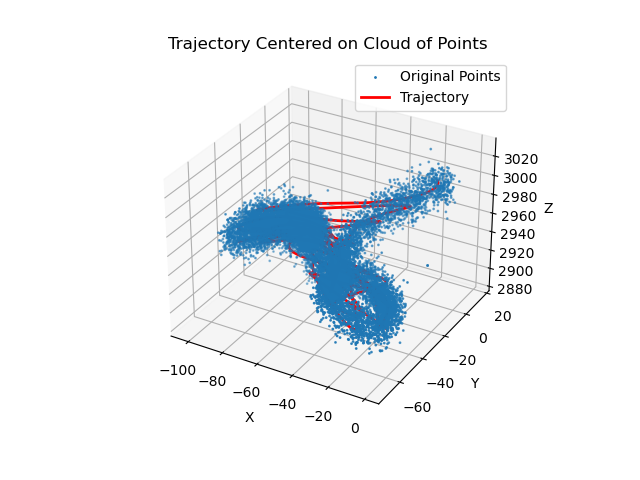

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.interpolate import splprep, splev

# Assuming your DataFrame is named 'data'
# Ensure the DataFrame contains the required columns
required_columns = ['x', 'y', 'z']
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"DataFrame must contain columns: {required_columns}")

# Convert DataFrame to numpy array
data_array = data[required_columns].to_numpy()

# Apply KMeans to find clusters
n_clusters = 50  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data_array)
centroids = kmeans.cluster_centers_

# Sort centroids to form a coherent path
centroids = centroids[np.argsort(centroids[:, 2])]

# Fit a spline through the centroids
tck, u = splprep([centroids[:, 0], centroids[:, 1], centroids[:, 2]], s=0.5)
u_fine = np.linspace(0, 1, 1000)
x_spline, y_spline, z_spline = splev(u_fine, tck)

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_array[:, 0], data_array[:, 1], data_array[:, 2], s=1, label='Original Points')
ax.plot(x_spline, y_spline, z_spline, 'r', linewidth=2, label='Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Trajectory Centered on Cloud of Points')
ax.legend()
plt.show()
